## ANALYSIS_6 - Correlation Matrix (Conversion and Attributes)

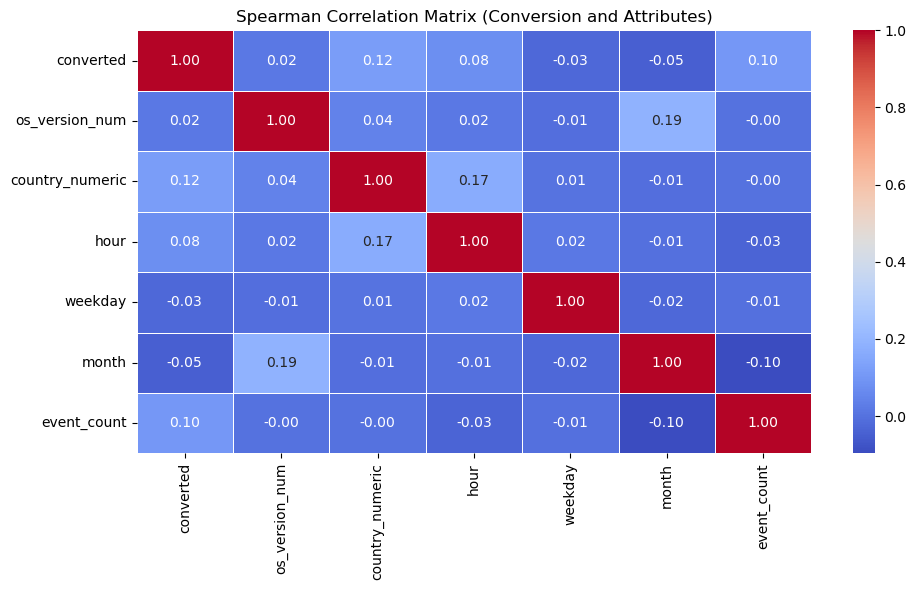

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieve path and file
source_dir = r"C:\Users\user\Desktop\.....\PY_10_PYClean_Source_V8"
file_path = os.path.join(source_dir, "user_level_master.csv")
df = pd.read_csv(file_path, parse_dates=["event_datetime"])

# Conversion label: if there was a trial_converted_event, then 1
df['converted'] = df['event_type'] == 'trial_converted_event'
conversion_df = df.groupby('distinct_id')['converted'].max().reset_index()

# Convert OS version to numeric form
def convert_os_version(version):
    try:
        parts = version.split('.')
        return float(parts[0] + '.' + ''.join(parts[1:]))
    except:
        return np.nan

os_versions = df[['distinct_id', 'os_version']].dropna().drop_duplicates()
os_versions['os_version_num'] = os_versions['os_version'].apply(convert_os_version)

# Convert country to numeric ID
countries = df[['distinct_id', 'country_code']].dropna().drop_duplicates()
countries['country_numeric'] = countries['country_code'].astype('category').cat.codes

# Trial start event timings
trial_start_times = df[df['event_type'] == 'trial_started_event'][['distinct_id', 'event_datetime']].rename(columns={"event_datetime": "trial_start_time"})
trial_start_times['hour'] = trial_start_times['trial_start_time'].dt.hour
trial_start_times['weekday'] = trial_start_times['trial_start_time'].dt.weekday
trial_start_times['month'] = trial_start_times['trial_start_time'].dt.month

# Number of event activities (trial events)
event_counts = df[df['event_type'].str.contains('trial')].groupby('distinct_id').size().reset_index(name='event_count')

# Master DataFrame for correlation
correlation_df = conversion_df.merge(os_versions[['distinct_id', 'os_version_num']], on='distinct_id', how='left')
correlation_df = correlation_df.merge(countries[['distinct_id', 'country_numeric']], on='distinct_id', how='left')
correlation_df = correlation_df.merge(trial_start_times[['distinct_id', 'hour', 'weekday', 'month']], on='distinct_id', how='left')
correlation_df = correlation_df.merge(event_counts, on='distinct_id', how='left')

# Spearman correlation matrix
corr_matrix = correlation_df.drop(columns=['distinct_id']).corr(method='spearman')

# Results announcement
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Matrix (Conversion and Attributes)")
plt.tight_layout()
plt.show()

## Correlation (OS version, Countrycode and Event activations)

C:\Users\user\AppData\Local\Temp\ipykernel_13508\1266225211.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


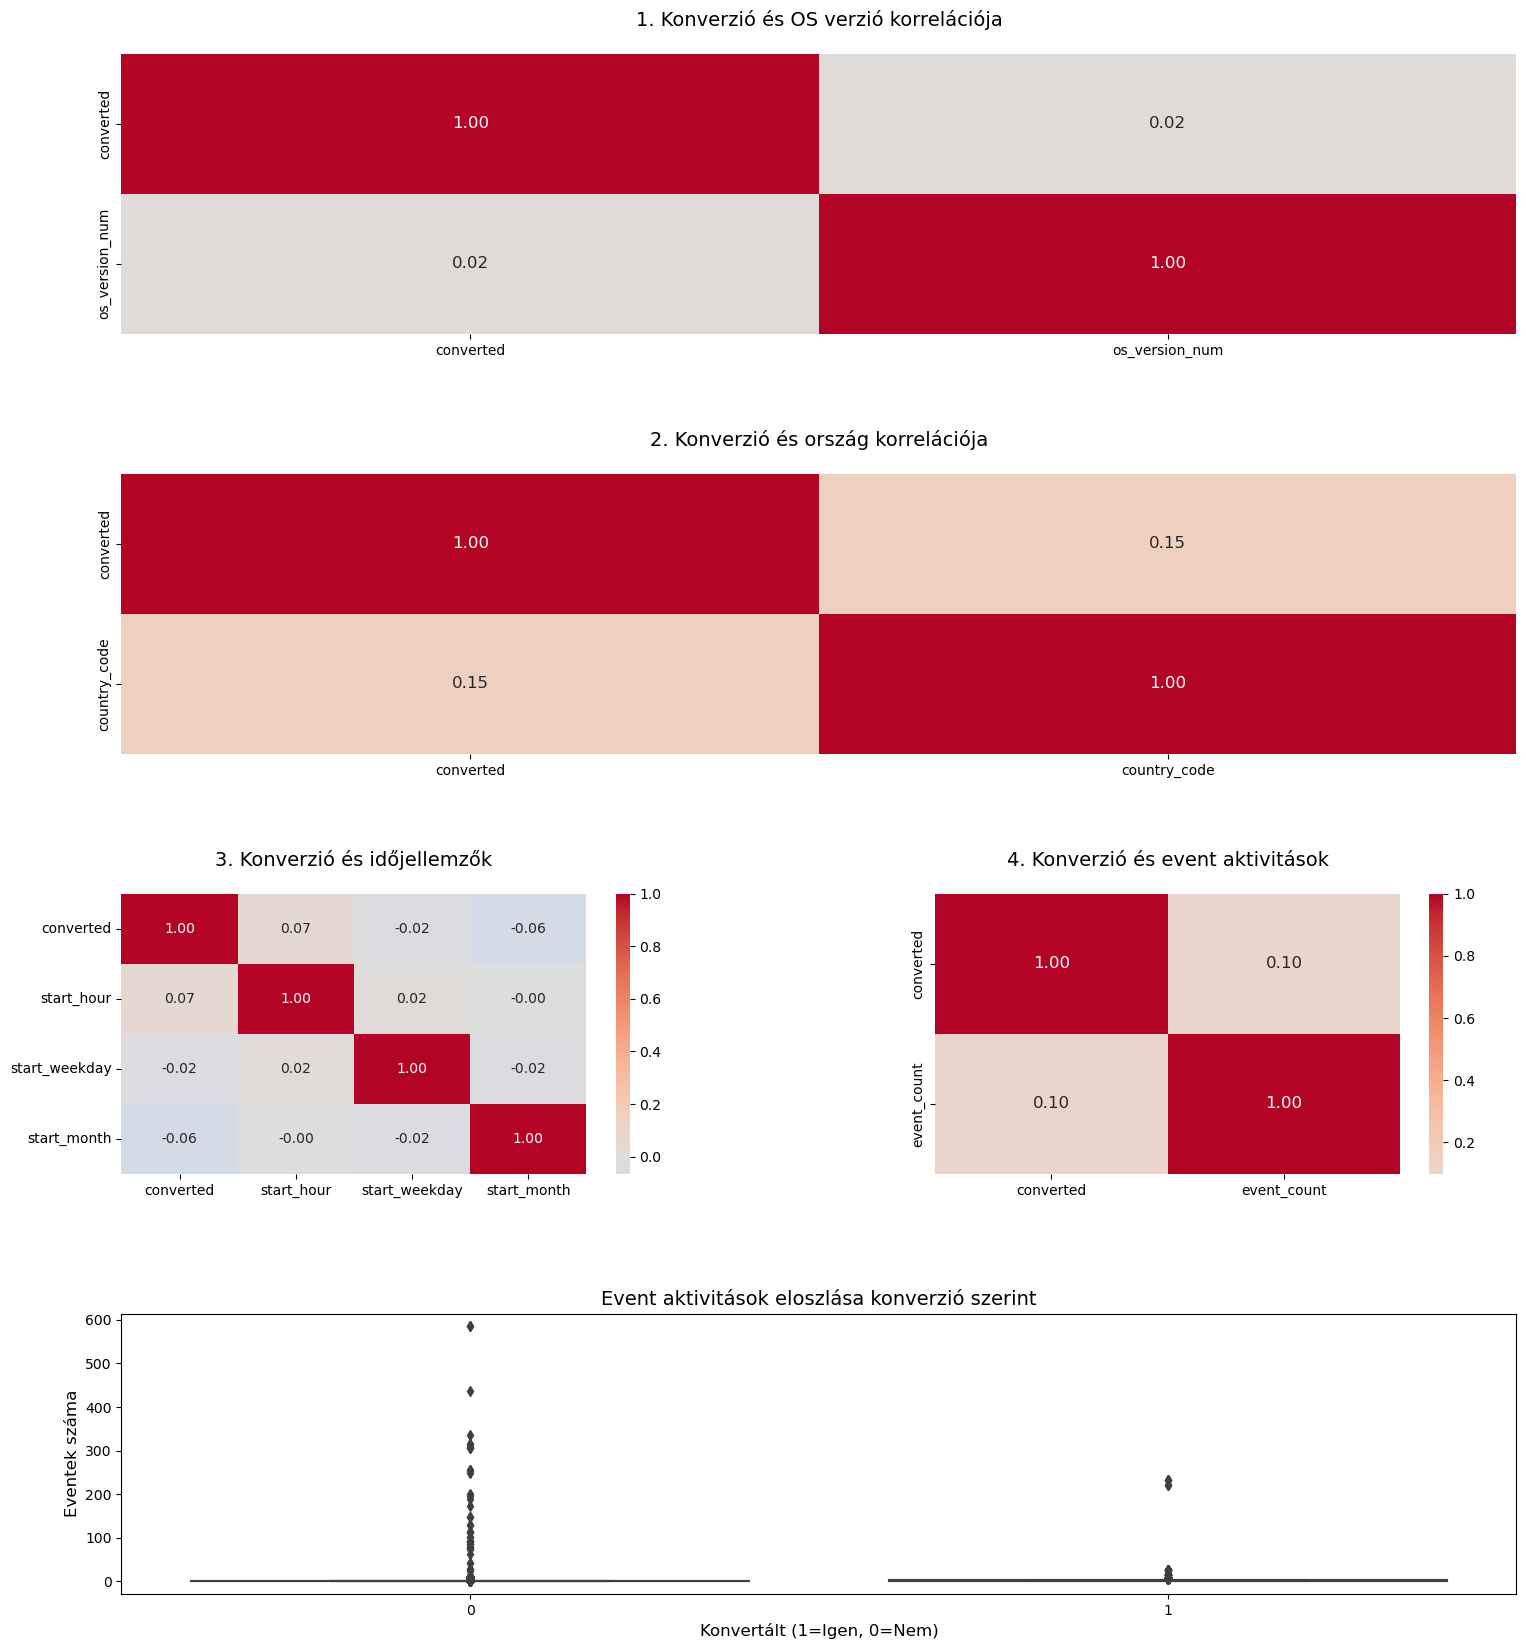

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Data load and preparation
source_dir = r"C:\Users\user\Desktop\.....\PY_10_PYClean_Source_V8"
file_path = os.path.join(source_dir, "user_level_master.csv")
df = pd.read_csv(file_path, parse_dates=["event_datetime"])

# Create a conversion label
df['converted'] = df['event_type'] == 'trial_converted_event'
conversion_df = df.groupby('distinct_id')['converted'].max().astype(int).reset_index()

# Convert OS version to numeric form
def convert_os_version(version):
    try:
        parts = str(version).split('.')
        return float(parts[0] + '.' + ''.join(parts[1:3])) if len(parts) > 1 else float(parts[0])
    except:
        return np.nan

os_versions = df[['distinct_id', 'os_version']].dropna().drop_duplicates()
os_versions['os_version_num'] = os_versions['os_version'].apply(convert_os_version)

# Country management (keep top 10 countries, others "Other")
top_countries = df['country_code'].value_counts().nlargest(10).index
countries = df[['distinct_id', 'country_code']].dropna().drop_duplicates()
countries['country_group'] = np.where(countries['country_code'].isin(top_countries), 
                                    countries['country_code'], 'Other')
countries['country_code'] = countries['country_group'].astype('category').cat.codes

# Trial start time characteristics
trial_start_times = df[df['event_type'] == 'trial_started_event'][['distinct_id', 'event_datetime']].drop_duplicates()
trial_start_times['start_hour'] = trial_start_times['event_datetime'].dt.hour
trial_start_times['start_weekday'] = trial_start_times['event_datetime'].dt.weekday
trial_start_times['start_month'] = trial_start_times['event_datetime'].dt.month

# Number of event activities during trial
event_counts = df[df['event_type'].str.contains('trial')].groupby('distinct_id').size().reset_index(name='event_count')

# Compile Master DataFrame
master_df = conversion_df.merge(os_versions[['distinct_id', 'os_version_num']], on='distinct_id', how='left')
master_df = master_df.merge(countries[['distinct_id', 'country_code']], on='distinct_id', how='left')
master_df = master_df.merge(trial_start_times[['distinct_id', 'start_hour', 'start_weekday', 'start_month']], on='distinct_id', how='left')
master_df = master_df.merge(event_counts, on='distinct_id', how='left')

# Creating correlation matrices
plt.figure(figsize=(18, 20))
gs = GridSpec(4, 2, height_ratios=[1, 1, 1, 1], hspace=0.5, wspace=0.4)

# - 1 Conversion & OS version
plt.subplot(gs[0, :])
os_corr = master_df[['converted', 'os_version_num']].corr(method='spearman')
sns.heatmap(os_corr, annot=True, cmap='coolwarm', fmt=".2f", center=0, 
            annot_kws={"size": 12}, cbar=False)
plt.title("1. Konverzió és OS verzió korrelációja", pad=20, fontsize=14)

# - 2 Conversion & Country
plt.subplot(gs[1, :])
country_corr = master_df[['converted', 'country_code']].corr(method='spearman')
sns.heatmap(country_corr, annot=True, cmap='coolwarm', fmt=".2f", center=0,
            annot_kws={"size": 12}, cbar=False)
plt.title("2. Konverzió és ország korrelációja", pad=20, fontsize=14)

# - 3 Conversion & trial start date
plt.subplot(gs[2, 0])
time_corr = master_df[['converted', 'start_hour', 'start_weekday', 'start_month']].corr(method='spearman')
sns.heatmap(time_corr, annot=True, cmap='coolwarm', fmt=".2f", center=0,
            annot_kws={"size": 10})
plt.title("3. Konverzió és időjellemzők", pad=20, fontsize=14)

# - 4 Conversion & Event activities
plt.subplot(gs[2, 1])
activity_corr = master_df[['converted', 'event_count']].corr(method='spearman')
sns.heatmap(activity_corr, annot=True, cmap='coolwarm', fmt=".2f", center=0,
            annot_kws={"size": 12})
plt.title("4. Konverzió és event aktivitások", pad=20, fontsize=14)

# - 5 More visualizations
plt.subplot(gs[3, :])
sns.boxplot(x='converted', y='event_count', data=master_df)
plt.title("Event aktivitások eloszlása konverzió szerint", fontsize=14)
plt.xlabel("Konvertált (1=Igen, 0=Nem)", fontsize=12)
plt.ylabel("Eventek száma", fontsize=12)

plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_7292\4273082309.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  converted_users['conversion'] = 1


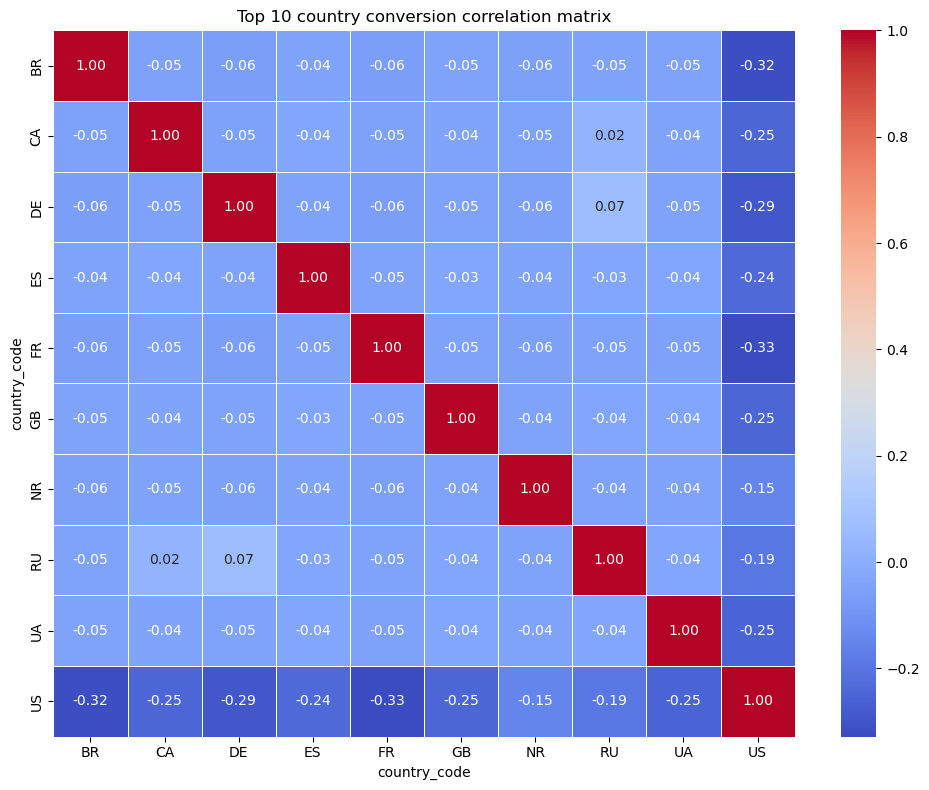

In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

file_path = r"C:\Users\user\Desktop\.....\PY_10_PYClean_Source_V8\user_level_master.csv"
df = pd.read_csv(file_path)

# Keep only the necessary columns and filter out empty country_code values
df = df[['distinct_id', 'event_type', 'country_code']]
df = df.dropna(subset=['country_code'])

# Trial Started & Converted
trial_started = df[df['event_type'] == 'trial_started_event']
trial_converted = df[df['event_type'] == 'trial_converted_event']

# Only those converters who have previously started a trial
converted_users = trial_converted[trial_converted['distinct_id'].isin(trial_started['distinct_id'])]

# Conversion flagging
converted_users['conversion'] = 1

# Selecting top 10 countries based on conversions
top_10_countries = (
    converted_users.groupby('country_code')['distinct_id']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Only use data from the top 10 countries
filtered_users = converted_users[converted_users['country_code'].isin(top_10_countries)]

# Pivot table: user × country conversion binary matrix
pivot_df = filtered_users.pivot_table(
    index='distinct_id',
    columns='country_code',
    values='conversion',
    fill_value=0
)

# Correlation matrix
corr_matrix = pivot_df.corr(method='pearson')

# Show Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Top 10 country conversion correlation matrix")
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_1636\1343536280.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  converted_users['conversion'] = 1  # Flag


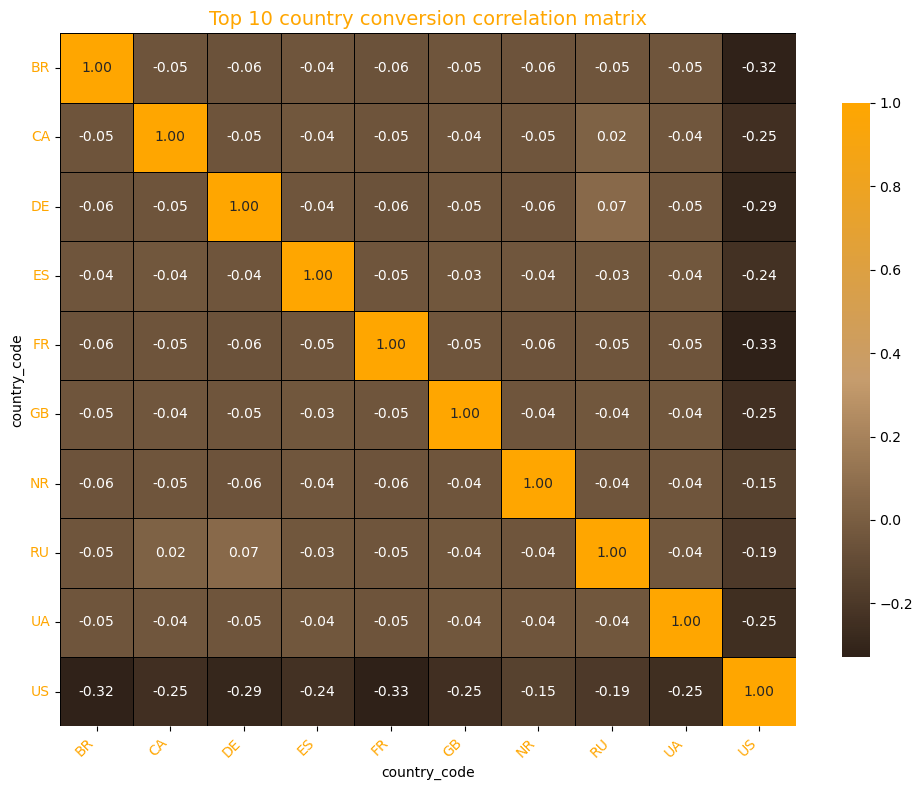

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 1. Adatok betöltése
file_path = r"C:\Users\user\Desktop\PROMETHEUS\2024_PROJECT - GITHUB\AAA_REFERENCIA_PREZIK\PREZI_10 - TELEPROMPTER\PY_10_PYClean_Source_V8\user_level_master.csv"
       
df = pd.read_csv(file_path)

# 2. Csak szükséges oszlopok + hiányzó országkód eltávolítása
df = df[['distinct_id', 'event_type', 'country_code']]
df = df.dropna(subset=['country_code'])

# 3. Trial started / converted szétválasztása
trial_started = df[df['event_type'] == 'trial_started_event']
trial_converted = df[df['event_type'] == 'trial_converted_event']

# 4. Csak azok a konvertáltak, akik előzőleg kezdtek próbát
converted_users = trial_converted[trial_converted['distinct_id'].isin(trial_started['distinct_id'])]
converted_users['conversion'] = 1  # Flag

# 5. Top 10 ország kiválasztása
top_10_countries = (
    converted_users.groupby('country_code')['distinct_id']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 6. Csak top 10 ország adatai
filtered_users = converted_users[converted_users['country_code'].isin(top_10_countries)]

# 7. Pivot tábla: user × country (bináris)
pivot_df = filtered_users.pivot_table(
    index='distinct_id',
    columns='country_code',
    values='conversion',
    fill_value=0
)

# 8. Korrelációs mátrix
corr_matrix = pivot_df.corr(method='pearson')

# 9. Sárgás-barna egyéni színskála
colors = ["#2f2118", "#c69c6d", "#ffa600"]
custom_cmap = LinearSegmentedColormap.from_list("okker_brown", colors)

# 10. Hőtérkép megjelenítése
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=custom_cmap, fmt=".2f", linewidths=0.5,
            linecolor='black', cbar_kws={'shrink': 0.8})

plt.title("Top 10 country conversion correlation matrix", color='#ffa600', fontsize=14)
plt.xticks(rotation=45, ha='right', color='#ffa600')
plt.yticks(rotation=0, color='#ffa600')

# Keret és címkék színezése
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('#ffa600')

plt.tight_layout()
plt.show()
